In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from geopy.distance import geodesic

In [ ]:
diary = pd.read_csv("./data-sources/flightdiary.csv", header=1)

#Gathering filenames
diary["PathFile"] = diary.Date.str[2:] + "-" + diary.FlightNumber

# Splitting airport information
diary["FromICAO"] = diary.From.str[-5:-1]
diary["FromIATA"] = diary.From.str[-9:-6]
diary["FromCity"] = diary.From.str.split("/").str[0]
diary.FromCity = diary.FromCity.str[:-1]
diary.From = diary.From.str.split("/").str[1]
diary.From = diary.From.str[:-5]
diary["ToICAO"] = diary.To.str[-5:-1]
diary["ToIATA"] = diary.To.str[-9:-6]
diary["ToCity"] = diary.To.str.split("/").str[0]
diary.ToCity = diary.ToCity.str[:-1]
diary.To = diary.To.str.split("/").str[1]
diary.To = diary.To.str[:-5]

# Splitting airline information
diary["AirlineICAO"] = diary.Airline.str[-4:-1]
diary["AirlineIATA"] = diary.Airline.str[-7:-5]
diary.Airline = diary.Airline.str[:-9]
diary["AirlineColor"] = diary.AirlineICAO

# Prettifying names of cities, airports and airlines
diary.FromCity = diary.FromCity.str.replace("Istanbul", "İstanbul").str.replace("Izmir", "İzmir").str.replace("Antakya", "Hatay").str.replace("Ercan", "Nicosia").str.replace("Tromso", "Tromsø").str.replace("Sharm el Sheikh", "Sharm El-Sheikh")
diary.ToCity = diary.ToCity.str.replace("Istanbul", "İstanbul").str.replace("Izmir", "İzmir").str.replace("Antakya", "Hatay").str.replace("Ercan", "Nicosia").str.replace("Tromso", "Tromsø").str.replace("Sharm el Sheikh", "Sharm El-Sheikh")
diary.From = diary.From.str.replace("Ataturk", "Atatürk").str.replace("Sabiha Gokcen", "Sabiha Gökçen").str.replace("Sakirpasa", "Şakirpaşa").str.replace("Hatay", "Antakya").str.replace("Carsamba", "Çarşamba").str.replace("Esenboga", "Esenboğa").str.replace("Sharm el-Sheik Intl", "Sharm El-Sheikh").str.replace("Mersin Cukurova International Airport", "Çukurova").str.replace("Nikola Tesla Beograd", "Nikola Tesla").str.replace("MR Stefanik", "M. R. Štefánik")
diary.To = diary.To.str.replace("Ataturk", "Atatürk").str.replace("Sabiha Gokcen", "Sabiha Gökçen").str.replace("Sakirpasa", "Şakirpaşa").str.replace("Hatay", "Antakya").str.replace("Carsamba", "Çarşamba").str.replace("Esenboga", "Esenboğa").str.replace("Sharm el-Sheik Intl", "Sharm El-Sheikh").str.replace("Mersin Cukurova International Airport", "Çukurova").str.replace("Nikola Tesla Beograd", "Nikola Tesla").str.replace("MR Stefanik", "M. R. Štefánik")
diary.Airline = diary.Airline.str.replace("Transavia.com France","Transavia").replace("Norwegian Air International","Norwegian Air").replace("Pegasus Airlines","Pegasus").replace("AJet Airlines","AJet")
diary.AirlineColor = diary.AirlineICAO.str.replace("THY", "#ff0000").str.replace("PGT", "#ff8c00").str.replace("MSC", "#8000a4").str.replace("TKJ", "#00ABC9").str.replace("TVF", "#00a706").str.replace("AJA", "#216FFF").str.replace("SAS", "#0000FF").str.replace("SXS", "#F5DD00").str.replace("IBK", "#ff7171")
ad = diary.FromICAO.tolist()
for i in range(len(ad)):
    if ad[i][:2] in ["LT","HE"] or ad[i] == "LCEN": ad[i] = "03"
    elif ad[i][:2] in ["EF","LY","LI","LZ","LO"]: ad[i] = "02"
    elif ad[i][:2] in ["EN","ES","LF","EG"]: ad[i] = "01"
    else: ad[i] = "ERR"
diary["PortTZ"] = ad
diary.Departure = pd.to_datetime(diary.Date + " " + diary.Departure, utc=True).dt.strftime('%Y-%m-%d %H:%M:%S%z')
diary.Departure = pd.to_datetime(diary.Departure.str[:-4] + diary.PortTZ + ':' + diary.Departure.str[-2:], utc=True).apply(lambda x: x.timestamp()).astype(int)
diary.Duration = diary.Duration.str[:-3]
diary.Duration = ((diary.Duration.str[:-3].astype(int) * 60) + diary.Duration.str[-2:].astype(int)) * 60
diary.Arrival = diary.Departure + diary.Duration
diary.Duration = diary.Duration.astype(int)
diary.pop("PortTZ")

metars = {}
# Converting date & time to timestamps for METAR
for f in os.listdir("./data-sources/metar"):
    if (os.path.exists("./data-sources/metar/"+f) and os.path.isfile("./data-sources/metar/"+f)):
        metar = pd.read_csv("./data-sources/metar/"+f, low_memory=False)
        metar["valid"] = pd.to_datetime(metar["valid"], utc=True)
        metar["valid"] = metar["valid"].astype(int) / 1000000000
        metar["valid"] = metar["valid"].astype(int)
        metar["skyc1"] = metar["skyc1"].replace("", "CLR")
        metar["skyc2"] = metar["skyc2"].replace("", "CLR")
        metar["skyc3"] = metar["skyc3"].replace("", "CLR")
        metar["skyc4"] = metar["skyc4"].replace("", "CLR")
        for index, row in metar.iterrows():
            ceiling = 100000
            if row["skyc1"] in ["BKN", "OVC"]:
                ceiling = row["skyl1"]
            elif row["skyc2"] in ["BKN", "OVC"]:
                ceiling = row["skyl2"]
            elif row["skyc3"] in ["BKN", "OVC"]:
                ceiling = row["skyl3"]
            elif row["skyc4"] in ["BKN", "OVC"]:
                ceiling = row["skyl4"]
            metar.at[index, "skyc"] = ceiling
        metar["gust"] = metar["gust"].fillna(metar["sknt"])
        metar['wxcodes'] = metar['wxcodes'].fillna('CLEAR')
        metar['vsby'] = pd.to_numeric(metar['vsby'], errors='coerce')
        metar['drct'] = metar['drct'].fillna(0)
        cols = ["station","valid","tmpf","dwpf","relh","drct","sknt","p01i","alti","vsby","gust","skyc","wxcodes","feel"]
        metar = metar[cols]
        metars[f[0:4]] = metar

# Merging some data
paths = diary.PathFile.tolist()
diary["LinearDistance"] = np.nan
diary["FirstOnRadar"] = np.nan
diary["ActualDistance"] = np.nan
diary["ActualDeparture"] = np.nan
diary["ActualArrival"] = np.nan
diary["FlightTime"] = np.nan
diary["LastOnRadar"] = np.nan
diary["PlannedDepartureMETAR"] = np.nan
for p in range(len(paths)):
    if (os.path.exists("./data-sources/allflights/"+paths[p]+".csv") and os.path.isfile("./data-sources/allflights/"+paths[p]+".csv")):
        coords = pd.read_csv("./data-sources/allflights/"+paths[p]+".csv")
        startindex = (coords.Altitude != 0).idxmax()
        endindex = (coords.Altitude != 0).idxmin()
        if endindex == 0:
            endindex = coords.Altitude.size - 1
        startc = coords.Position[startindex]
        endc = coords.Position[endindex]
        timediff = coords.Timestamp[endindex] - coords.Timestamp[startindex]
        lineardistance = geodesic(startc,endc).meters
        actualdistance = 0
        diary.loc[p, "FirstOnRadar"] = coords.Timestamp[0].astype(int)
        diary.loc[p, "LastOnRadar"] = coords.Timestamp.iat[-1].astype(int)
        for i in range(startindex,endindex-1,1):
            actualdistance += geodesic(coords.Position[i],coords.Position[i+1]).meters
        diary.loc[p, "LinearDistance"] = lineardistance / 1000
        diary.loc[p, "ActualDistance"] = actualdistance / 1000
        diary.loc[p, "FlightTime"] = timediff.astype(int)
        diary.loc[p, "ActualDeparture"] = coords.Timestamp[startindex]
        diary.loc[p, "ActualArrival"] = coords.Timestamp[endindex]
    else:
        diary.loc[p, "PathFile"] = np.nan
diary = diary.dropna(subset=['PathFile'])

# Merging metar with flights
for index, row in diary.iterrows():
    metarDep = metars[row["FromICAO"]]
    metarArr = metars[row["ToICAO"]]
    strtDep = row["Departure"] - 3000
    if (row["Departure"] > row["FirstOnRadar"]):
        strDep = row["FirstOnRadar"] - 3000
    fnshDep = row["ActualDeparture"] + 1200
    strtArr = row["ActualArrival"] - 3900
    fnshArr = row["LastOnRadar"] + 1200
    print(row["PathFile"] + " > " + str(strtDep) + "-" + str(fnshDep) + " | " + str(strtArr) + "-" + str(fnshArr))
    maskDep = (metarDep['valid'] > strtDep) & (metarDep['valid'] < fnshDep)
    maskArr = (metarArr['valid'] > strtArr) & (metarArr['valid'] < fnshArr)
    wndwDep = metarDep.loc[maskDep]
    wndwArr = metarArr.loc[maskArr]
    wndw = pd.concat([wndwDep, wndwArr], ignore_index=True)
    wndw.to_csv("./data-sources/metar_flights/"+row["PathFile"]+".csv",index=False)
    

#Reordering columns
cols = diary.columns.tolist()
cols.insert(2, cols.pop(cols.index('FromCity')))
cols.insert(4, cols.pop(cols.index('FromICAO')))
cols.insert(5, cols.pop(cols.index('FromIATA')))
cols.insert(6, cols.pop(cols.index('ToIATA')))
cols.insert(7, cols.pop(cols.index('ToICAO')))
cols.insert(8, cols.pop(cols.index('ToCity')))
cols.insert(14, cols.pop(cols.index('AirlineICAO')))
cols.insert(15, cols.pop(cols.index('AirlineIATA')))
cols.pop(23)
cols.pop(23)
cols.pop(23)
cols.pop(23)
cols.insert(16, cols.pop(cols.index("AirlineColor")))
cols.insert(12, cols.pop(cols.index('ActualDeparture')))
cols.insert(13, cols.pop(cols.index('ActualArrival')))
diary = diary[cols]
diary = diary.sort_values('Departure')


diary.to_csv("./data-sources/cleandiary.csv", index=False)

23-08-02-PC1854 > 1690977000-1690984761.0 | 1690981732.0-1690986832.0
23-08-05-PC1853 > 1691231400-1691235828.0 | 1691232656.0-1691237756.0
23-09-02-TK7261 > 1693632300-1693638207.0 | 1693637490.0-1693642590.0
23-09-07-TK7260 > 1694056800-1694061682.0 | 1694060543.0-1694065643.0
23-09-23-PC2081 > 1695442500-1695446904.0 | 1695446201.0-1695451301.0
23-10-27-PC2094 > 1698417600-1698423725.0 | 1698422843.0-1698427943.0
23-10-29-PC2095 > 1698598200-1698603005.0 | 1698603282.0-1698608382.0
23-12-15-TK7262 > 1702658100-1702665268.0 | 1702664202.0-1702669302.0
23-12-17-TK7265 > 1702813800-1702819206.0 | 1702818589.0-1702823689.0
23-12-28-TK7266 > 1703777100-1703782206.0 | 1703781306.0-1703786406.0
24-01-01-TK7265 > 1704117600-1704125325.0 | 1704127490.0-1704132590.0
24-01-17-TK2464 > 1705498800-1705503856.0 | 1705503046.0-1705508146.0
24-02-12-TK7265 > 1707746400-1707751775.0 | 1707750961.0-1707756061.0
24-03-29-TK7262 > 1711730100-1711735214.0 | 1711734447.0-1711739547.0
24-04-07-VF3306 > 17

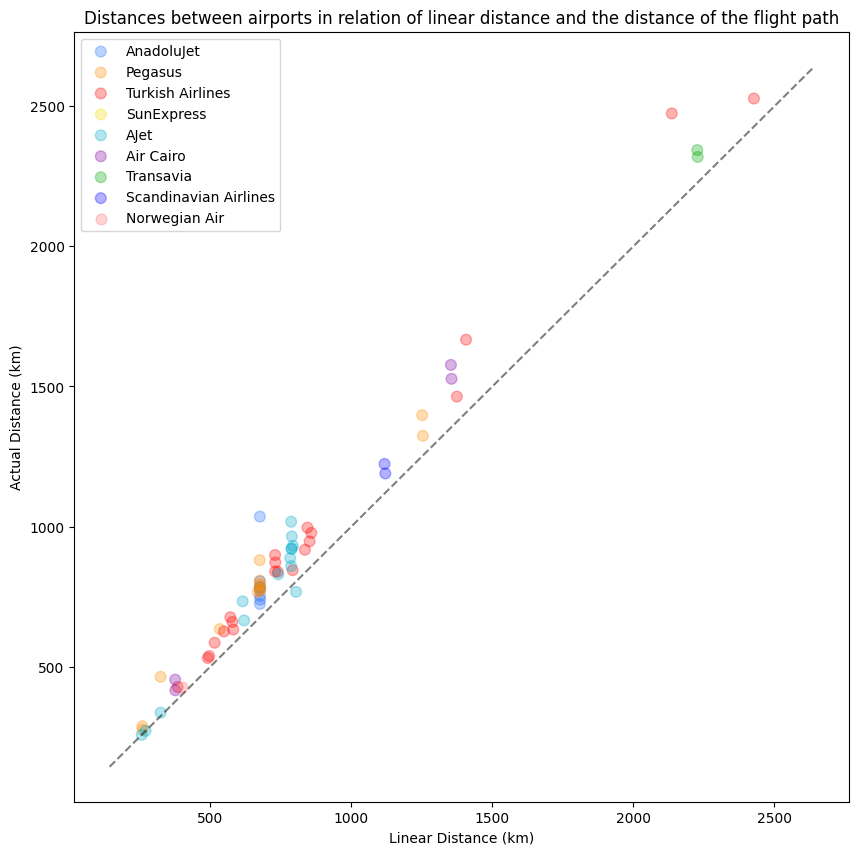

In [7]:
fig, ax = plt.subplots(figsize=(10, 10))
for a in diary['Airline'].unique():
    scatterthis = diary[(diary['Airline']==a)]
    ax.scatter(scatterthis['LinearDistance'], scatterthis['ActualDistance'], alpha=0.3, s=60, label=a, c=scatterthis['AirlineColor'])

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),
    np.max([ax.get_xlim(), ax.get_ylim()])
]
ax.plot(lims, lims, 'k--', alpha=0.5)
ax.set_xlabel('Linear Distance (km)')
ax.set_ylabel('Actual Distance (km)')
ax.set_title('Distances between airports in relation of linear distance and the distance of the flight path')
ax.legend()
plt.show()

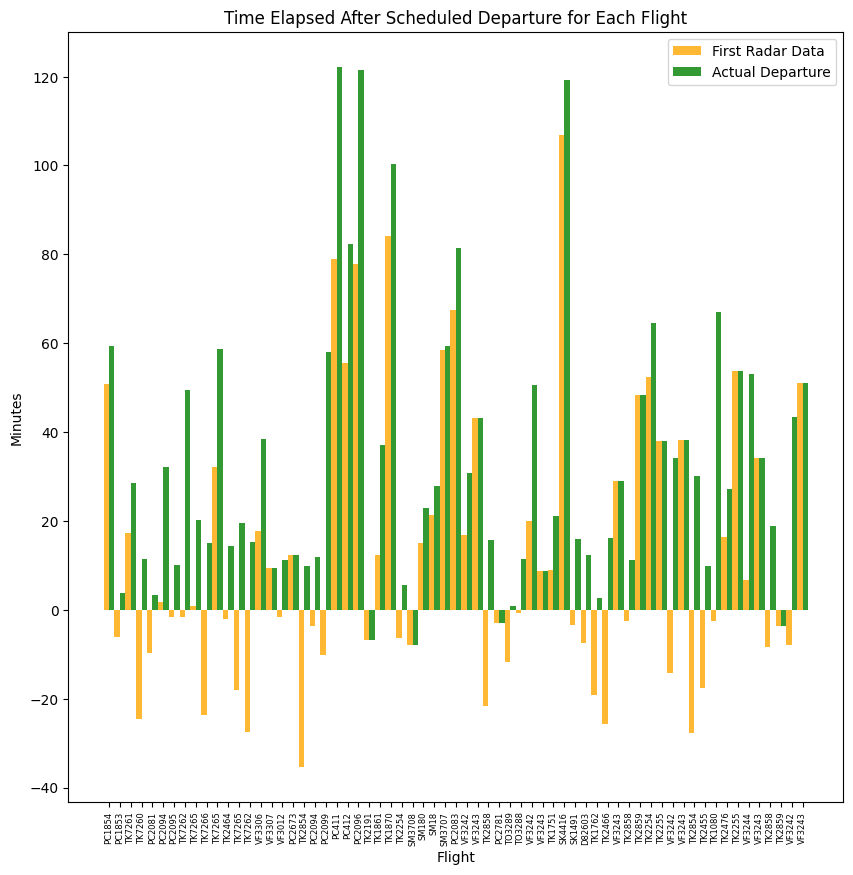

In [8]:
plottableflights = diary.copy()
plottableflights = plottableflights.dropna(subset=['LinearDistance', 'ActualDistance', 'FlightTime'])
plottableflights["FirstOnRadar"] = plottableflights["FirstOnRadar"].astype(int)
plottableflights["ActualDeparture"] = plottableflights["ActualDeparture"].astype(int)
plottableflights["ActualArrival"] = plottableflights["ActualArrival"].astype(int)
plottableflights["LastOnRadar"] = plottableflights["LastOnRadar"].astype(int)
plottableflights["FlightTime"] = plottableflights["FlightTime"].astype(int)

fig, ax = plt.subplots(figsize=(10, 10))
x = np.arange(len(plottableflights))
ax.bar(x - 0.25, (plottableflights['FirstOnRadar']-plottableflights['Departure'])/60, 0.5, label='First Radar Data', alpha=0.8, color="#ffa600")
ax.bar(x + 0.25, (plottableflights['ActualDeparture']-plottableflights['Departure'])/60, 0.5, label='Actual Departure', alpha=0.8, color="green")
ax.set_xlabel('Flight')
ax.set_ylabel('Minutes')
ax.set_title('Time Elapsed After Scheduled Departure for Each Flight')
ax.set_xticks(x)
ax.set_xticklabels(plottableflights['FlightNumber'], rotation=90, fontsize=6)
ax.legend()

plt.show()

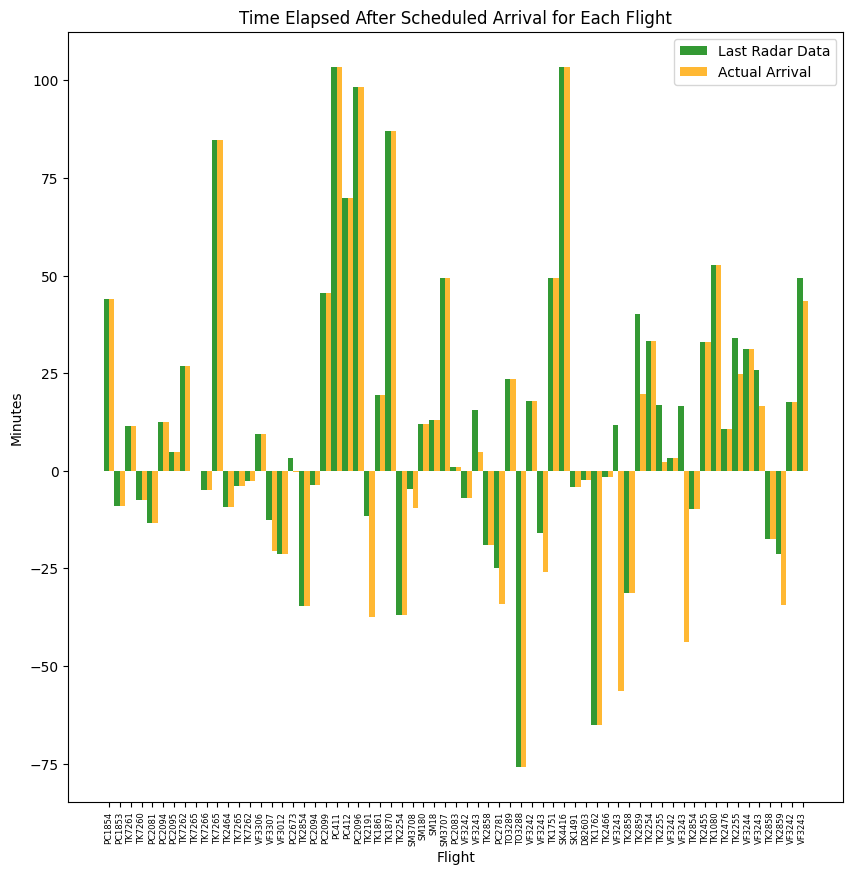

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))
x = np.arange(len(plottableflights))
ax.bar(x - 0.25, (plottableflights['LastOnRadar']-plottableflights['Arrival'])/60, 0.5, label='Last Radar Data', alpha=0.8, color="green")
ax.bar(x + 0.25, (plottableflights['ActualArrival']-plottableflights['Arrival'])/60, 0.5, label='Actual Arrival', alpha=0.8, color="#ffa600")
ax.set_xlabel('Flight')
ax.set_ylabel('Minutes')
ax.set_title('Time Elapsed After Scheduled Arrival for Each Flight')
ax.set_xticks(x)
ax.set_xticklabels(plottableflights['FlightNumber'], rotation=90, fontsize=6)
ax.legend()

plt.show()